In [1]:
import motif
import motif.plot
import numpy as np
import mir_eval
import os
import medleydb as mdb
import seaborn
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Do peak streaming on the outputs of the CNN (mdb test set)

In [1]:
etr_cnn = motif.contour_extractors.DeepSal()
with open("../data_splits.json", 'r') as fhandle:
    dat_dict = json.load(fhandle)

all_scores_mel1 = []
all_scores_mel2 = []
all_scores_mel3 = []
trackids = []
for track_id in dat_dict['test']:
    npy_path = "../experiment11b_output/fullmix_outputs/{}_prediction.npy".format(track_id)
    mtrack = mdb.MultiTrack(track_id)
    if os.path.exists(npy_path):
        print(track_id)
        trackids.append(track_id)
        ctr = etr_cnn.compute_contours(npy_path, mtrack.mix_path)

        scores_mel1 = ctr.coverage(mtrack.melody1_fpath, single_f0=True)
        scores_mel2 = ctr.coverage(mtrack.melody2_fpath, single_f0=True)
        scores_mel3 = ctr.coverage(mtrack.melody3_fpath, single_f0=False)
        print(scores_mel3['Recall'])
        
        all_scores_mel1.append(scores_mel1)
        all_scores_mel2.append(scores_mel2)
        all_scores_mel3.append(scores_mel3)

df_mel1 = pd.DataFrame(all_scores_mel1, index=trackids)
df_mel2 = pd.DataFrame(all_scores_mel2, index=trackids)
df_mel3 = pd.DataFrame(all_scores_mel3, index=trackids)

NameError: name 'motif' is not defined

In [1]:
df_mel1.describe()

NameError: name 'df_mel1' is not defined

In [ ]:
df_mel2.describe()

In [ ]:
df_mel3.describe()

In [ ]:
print(df_mel1['Recall'].mean())
print(df_mel2['Recall'].mean())
print(df_mel3['Recall'].mean())

df_mel1.to_csv("deepsal_mel1_coverage_test.csv")
df_mel2.to_csv("deepsal_mel2_coverage_test.csv")
df_mel3.to_csv("deepsal_mel3_coverage_test.csv")

In [ ]:
df_mel1 = pd.DataFrame.from_csv("deepsal_mel3_coverage_test.csv")
df_mel1.describe()

In [ ]:
seaborn.set_style('white')
etr_cnn = motif.contour_extractors.DeepSal()
track_id = "MusicDelta_Gospel"
npy_path = "../experiment11b_output/fullmix_outputs/{}_prediction.npy".format(track_id)
mtrack = mdb.MultiTrack(track_id)
ctr = etr_cnn.compute_contours(npy_path, mtrack.mix_path)

sal = np.load(npy_path)
plt.figure(figsize=(30, 30))
plt.subplot(2, 1, 1)
motif.plot.plot_with_annotation(ctr, mtrack.melody2_fpath, single_f0=False)
plt.subplot(2, 1, 2)
plt.imshow(sal, origin='lower', cmap='hot')
plt.axis('auto')

# plt.savefig('/Users/rabitt/Desktop/swingjazz.pdf', format='pdf')

### Compute recall of peak streaming 

### Compare with Justin's contour tracking

In [ ]:
etr_sal = motif.contour_extractors.Salamon()
with open("../data_splits.json", 'r') as fhandle:
    dat_dict = json.load(fhandle)

all_scores_mel1_sal = []
all_scores_mel2_sal = []
all_scores_mel3_sal = []
trackids = []
for track_id in dat_dict['test']:
    npy_path = "../experiment11b_output/fullmix_outputs/{}_prediction.npy".format(track_id)
    mtrack = mdb.MultiTrack(track_id)
    if os.path.exists(npy_path):
        print(track_id)
        trackids.append(track_id)
        ctr = etr_cnn.compute_contours(mtrack.mix_path)

        scores_mel1 = ctr.coverage(mtrack.melody1_fpath, single_f0=True)
        scores_mel2 = ctr.coverage(mtrack.melody2_fpath, single_f0=True)
        scores_mel3 = ctr.coverage(mtrack.melody3_fpath, single_f0=False)
        print(scores_mel3['Recall'])
        
        all_scores_mel1_sal.append(scores_mel1)
        all_scores_mel2_sal.append(scores_mel2)
        all_scores_mel3_sal.append(scores_mel3)

df_mel1 = pd.DataFrame(all_scores_mel1_sal, index=trackids)
df_mel2 = pd.DataFrame(all_scores_mel2_sal, index=trackids)
df_mel3 = pd.DataFrame(all_scores_mel3_sal, index=trackids)

In [ ]:
print(df_mel1['Recall'].mean())
print(df_mel2['Recall'].mean())
print(df_mel3['Recall'].mean())

In [ ]:
df_mel1.to_csv("salamon_mel1_coverage_test.csv")
df_mel2.to_csv("salamon_mel2_coverage_test.csv")
df_mel3.to_csv("salamon_mel3_coverage_test.csv")

In [ ]:
df_mel1 = pd.DataFrame.from_csv("salamon_mel3_coverage_test.csv")
df_mel1.describe()

### Get peak streaming output for all the training & validation files

In [10]:
with open("../data_splits.json", 'r') as fhandle:
    dat_dict = json.load(fhandle)

def get_file_pairs(track_id_list):
    file_pairs = []
    for track_id in track_id_list:
        mtrack = mdb.MultiTrack(track_id)
        if mtrack.dataset_version != 'V1':
            continue
        npy_path = "../experiment11b_output/fullmix_outputs/{}_prediction.npy".format(track_id)
        if os.path.exists(npy_path):
            file_pairs.append([npy_path, mtrack.mix_path, mtrack.melody2_fpath, track_id])
    return file_pairs
    
file_pairs_train = get_file_pairs(dat_dict['train'])
file_pairs_validate = get_file_pairs(dat_dict['validate'])
file_pairs_test = get_file_pairs(dat_dict['test'])

ftr_bitt = motif.feature_extractors.BitteliFeatures()

In [3]:
def get_XY_pairs(etr, ftr, file_pairs):
    contour_list = {}
    features_list = []
    labels_list = []

    for npy_file, mix_path, annotation, track_id in file_pairs:
        print(os.path.basename(mix_path))
        if etr.get_id() == 'salamon':
            ctr = etr.compute_contours(npy_file, mix_path)
        elif etr.get_id() == 'deepsal':
            ctr = etr.compute_contours(npy_file, mix_path)
        Y_train, _ = ctr.compute_labels(annotation)
        X_train = ftr.compute_all(ctr)

        features_list.append(X_train)
        labels_list.append(Y_train)
        contour_list[track_id] = ctr

    X = np.concatenate(features_list)
    Y = np.concatenate(labels_list)
    return X, Y, contour_list

#### Train CNN model for Melody

In [6]:
etr_cnn = motif.contour_extractors.DeepSal()
X_train_cnn, Y_train_cnn, train_contours_cnn = \
    get_XY_pairs(etr_cnn, ftr_bitt, file_pairs_train)

AimeeNorwich_Child_MIX.wav
AimeeNorwich_Flying_MIX.wav
AlexanderRoss_GoodbyeBolero_MIX.wav
AlexanderRoss_VelvetCurtain_MIX.wav
AmarLal_Rest_MIX.wav
AmarLal_SpringDay1_MIX.wav
AvaLuna_Waterduct_MIX.wav
BigTroubles_Phantom_MIX.wav
ClaraBerryAndWooldog_AirTraffic_MIX.wav
ClaraBerryAndWooldog_Boys_MIX.wav
ClaraBerryAndWooldog_Stella_MIX.wav
ClaraBerryAndWooldog_TheBadGuys_MIX.wav
ClaraBerryAndWooldog_WaltzForMyVictims_MIX.wav
CroqueMadame_Oil_MIX.wav
CroqueMadame_Pilot_MIX.wav
DreamersOfTheGhetto_HeavyLove_MIX.wav
EthanHein_1930sSynthAndUprightBass_MIX.wav
EthanHein_GirlOnABridge_MIX.wav
FacesOnFilm_WaitingForGa_MIX.wav
FamilyBand_Again_MIX.wav
Handel_TornamiAVagheggiar_MIX.wav
HeladoNegro_MitadDelMundo_MIX.wav
HopAlong_SisterCities_MIX.wav
InvisibleFamiliars_DisturbingWildlife_MIX.wav
JoelHelander_Definition_MIX.wav
JoelHelander_ExcessiveResistancetoChange_MIX.wav
JoelHelander_IntheAtticBedroom_MIX.wav
KarimDouaidy_Hopscotch_MIX.wav
KarimDouaidy_Yatora_MIX.wav
LizNelson_Coldwar_MIX.wav
Li

In [11]:
X_test_cnn, Y_test_cnn, test_contours_cnn = \
    get_XY_pairs(etr_cnn, ftr_bitt, file_pairs_test)

AClassicEducation_NightOwl_MIX.wav
Auctioneer_OurFutureFaces_MIX.wav
CelestialShore_DieForUs_MIX.wav
ChrisJacoby_BoothShotLincoln_MIX.wav
ChrisJacoby_PigsFoot_MIX.wav
Creepoid_OldTree_MIX.wav
Debussy_LenfantProdigue_MIX.wav
MatthewEntwistle_DontYouEver_MIX.wav
MatthewEntwistle_FairerHopes_MIX.wav
MatthewEntwistle_ImpressionsOfSaturn_MIX.wav
MatthewEntwistle_Lontano_MIX.wav
MatthewEntwistle_TheArch_MIX.wav
MatthewEntwistle_TheFlaxenField_MIX.wav
Mozart_DiesBildnis_MIX.wav
MusicDelta_FusionJazz_MIX.wav
MusicDelta_Gospel_MIX.wav
MusicDelta_Pachelbel_MIX.wav
MusicDelta_SwingJazz_MIX.wav
Phoenix_BrokenPledgeChicagoReel_MIX.wav
Phoenix_ColliersDaughter_MIX.wav
Phoenix_ElzicsFarewell_MIX.wav
Phoenix_LarkOnTheStrandDrummondCastle_MIX.wav
Phoenix_ScotchMorris_MIX.wav
Phoenix_SeanCaughlinsTheScartaglen_MIX.wav
PortStWillow_StayEven_MIX.wav
Schubert_Erstarrung_MIX.wav
StrandOfOaks_Spacestation_MIX.wav


In [7]:
clf_cnn = motif.contour_classifiers.RandomForest()
clf_cnn.fit(X_train_cnn, Y_train_cnn)

In [8]:
# get training score
Y_prob_cnn = clf_cnn.predict(X_train_cnn)
Y_pred_cnn = (np.array(Y_prob_cnn >= clf_cnn.threshold)).astype(int)
train_scores_cnn = clf_cnn.score(Y_pred_cnn, Y_train_cnn, y_prob=Y_prob_cnn)
print(train_scores_cnn)

{'f1': array([ 0.99976446,  0.98979196]), 'recall': array([ 0.99952903,  1.        ]), 'support': array([167738,   3830]), 'mcc': 0.98961041493119273, 'precision': array([ 1.        ,  0.97979023]), 'auc score': 1.0, 'confusion matrix': array([[167659,     79],
       [     0,   3830]]), 'accuracy': 0.99953954117317911}


In [12]:
Y_prob_cnn = clf_cnn.predict(X_test_cnn)
Y_pred_cnn = (np.array(Y_prob_cnn >= clf_cnn.threshold)).astype(int)
test_scores = clf_cnn.score(Y_pred_cnn, Y_test_cnn, y_prob=Y_prob_cnn)
print(test_scores)

{'f1': array([ 0.9918061 ,  0.55407711]), 'recall': array([ 0.99582038,  0.45439284]), 'support': array([79433,  1787]), 'mcc': 0.56042409459463904, 'precision': array([ 0.98782407,  0.70979021]), 'auc score': 0.94318901766352969, 'confusion matrix': array([[79101,   332],
       [  975,   812]]), 'accuracy': 0.98390790445703025}


### Evaluate contour classification

In [45]:
def get_contour_scores_cnn(etr, ftr, clf, contour_list):
    scores_list = {}

    for k, ctr in contour_list.items():
        print(k)
        X = ftr.compute_all(ctr)
        Y = clf.predict(X)
        scores_list[k] = Y

    return scores_list

# def get_contour_scores_sal(etr, ftr, clf, file_pairs):
#     contour_list = []
#     scores_list = []

#     for npy_file, mix_path, annotation in file_pairs:
#         print(os.path.basename(mix_path))
#         ctr = etr.compute_contours(mix_path)
#         X = ftr.compute_all(ctr)
#         Y = clf.predict(X)
#         contour_list.append(ctr)
#         scores_list.append(Y)

#     return contour_list, scores_list

def max_decode(ctr, Y, thresh=0.2):

    n_uniform_times = len(ctr.uniform_times)
    freqs = [[] for i in range(n_uniform_times)]
    scores = [[] for i in range(n_uniform_times)]

    time_idx = np.round(ctr.times * ctr.sample_rate).astype(int)
    time_idx[time_idx >= n_uniform_times] = n_uniform_times - 1
    for i, freq in zip(time_idx, ctr.freqs):
        n = ctr.index[i]
        if Y[n] >= thresh:
            freqs[i].append(freq)
        else:
            freqs[i].append(-1.0*freq)
        scores[i].append(Y[n])

    single_f0 = []
    for i, f in enumerate(freqs):
        if len(f) > 0:
            single_f0.append(f[np.argmax(scores[i])])
        else:
            single_f0.append(0.0)

    return np.array(ctr.uniform_times), np.array(single_f0)

def weighted_max_decode(ctr, Y, thresh=0.2):

    n_uniform_times = len(ctr.uniform_times)
    freqs = [[] for i in range(n_uniform_times)]
    scores = [[] for i in range(n_uniform_times)]

    time_idx = np.round(ctr.times * ctr.sample_rate).astype(int)
    time_idx[time_idx >= n_uniform_times] = n_uniform_times - 1
    for i, freq in zip(time_idx, ctr.freqs):
        n = ctr.index[i]
        if Y[n] >= thresh:
            freqs[i].append(freq)
        else:
            freqs[i].append(-1.0*freq)
        scores[i].append(Y[n]*ctr.salience[i])

    single_f0 = []
    for i, f in enumerate(freqs):
        if len(f) > 0:
            single_f0.append(f[np.argmax(scores[i])])
        else:
            single_f0.append(0.0)

    return np.array(ctr.uniform_times), np.array(single_f0)

In [16]:
# valid_scores_cnn = get_contour_scores_cnn(
#     etr_cnn, ftr_bitt, clf_cnn, file_pairs_validate
# )

test_scores_cnn = get_contour_scores_cnn(
    etr_cnn, ftr_bitt, clf_cnn, test_contours_cnn
)

Phoenix_SeanCaughlinsTheScartaglen
Schubert_Erstarrung
Phoenix_ColliersDaughter
AClassicEducation_NightOwl
Phoenix_LarkOnTheStrandDrummondCastle
ChrisJacoby_PigsFoot
Mozart_DiesBildnis
MatthewEntwistle_TheArch
Auctioneer_OurFutureFaces
MatthewEntwistle_DontYouEver
PortStWillow_StayEven
MusicDelta_FusionJazz
Phoenix_BrokenPledgeChicagoReel
MatthewEntwistle_FairerHopes
Debussy_LenfantProdigue
Creepoid_OldTree
MusicDelta_SwingJazz
MatthewEntwistle_Lontano
CelestialShore_DieForUs
MusicDelta_Pachelbel
ChrisJacoby_BoothShotLincoln
StrandOfOaks_Spacestation
Phoenix_ElzicsFarewell
MusicDelta_Gospel
MatthewEntwistle_ImpressionsOfSaturn
MatthewEntwistle_TheFlaxenField
Phoenix_ScotchMorris


In [21]:
test_scores_cnn = test_scores_cnn[1]

Phoenix_SeanCaughlinsTheScartaglen


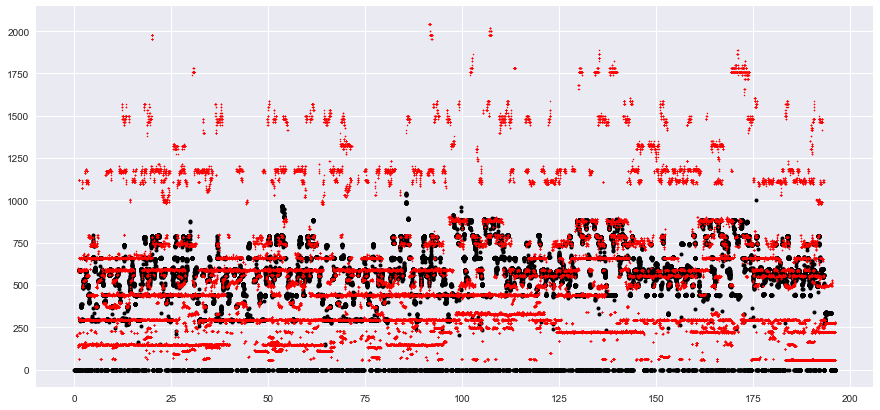

Schubert_Erstarrung


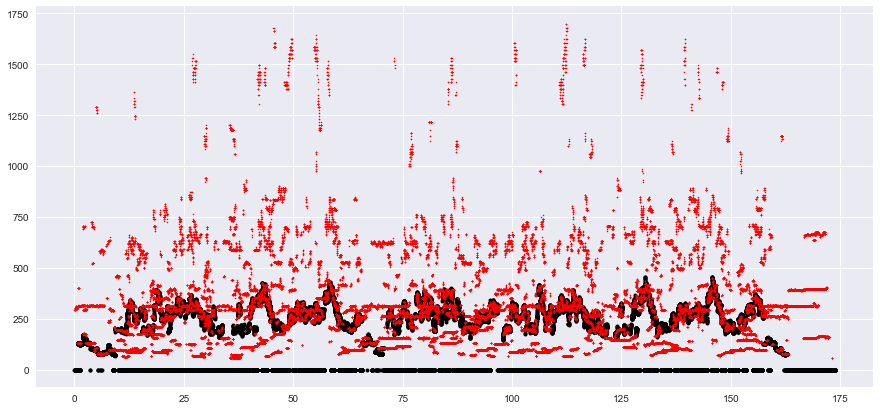

Phoenix_ColliersDaughter


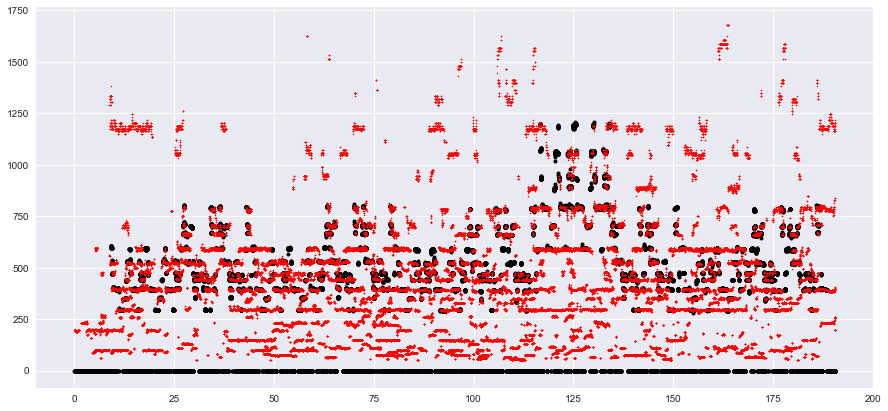

AClassicEducation_NightOwl


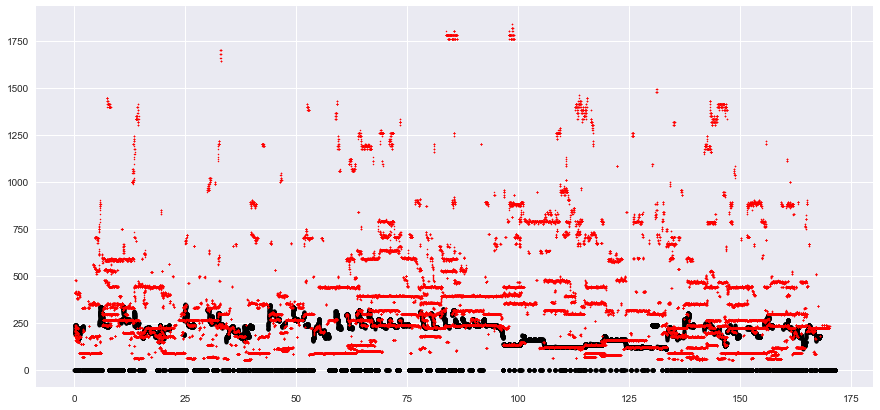

Phoenix_LarkOnTheStrandDrummondCastle


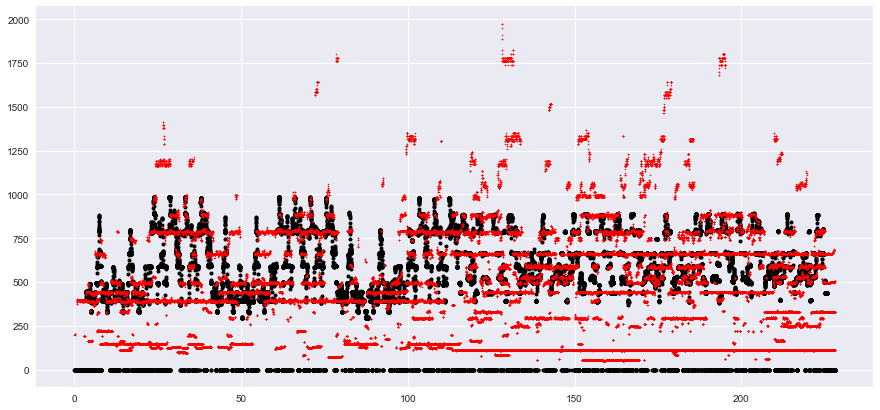

ChrisJacoby_PigsFoot


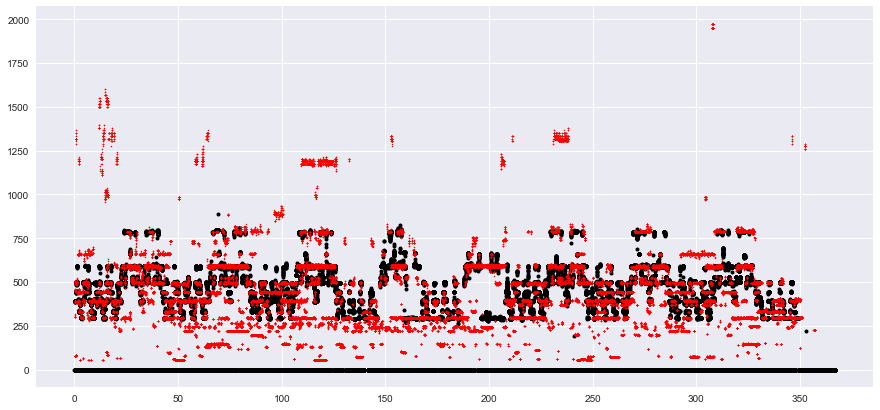

Mozart_DiesBildnis


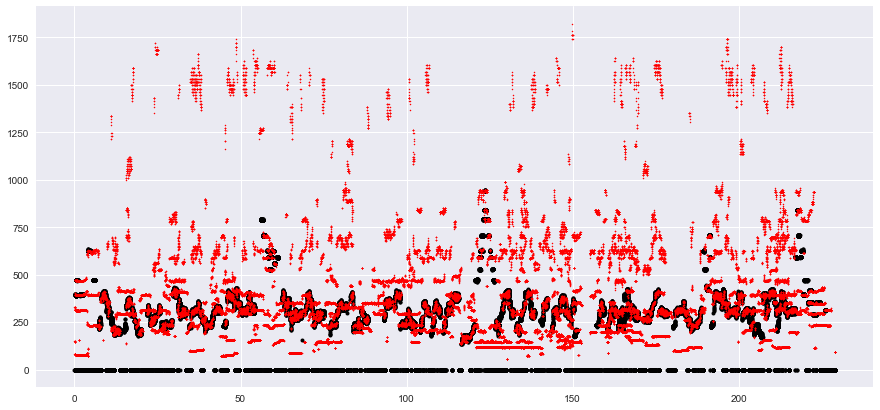

MatthewEntwistle_TheArch


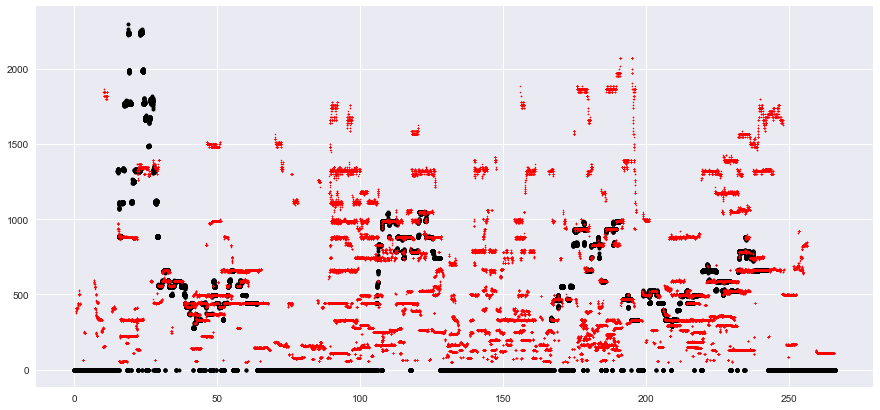

Auctioneer_OurFutureFaces


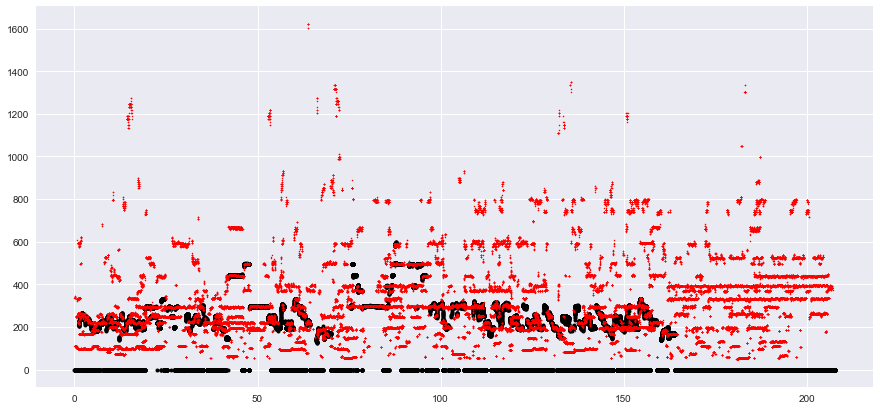

MatthewEntwistle_DontYouEver


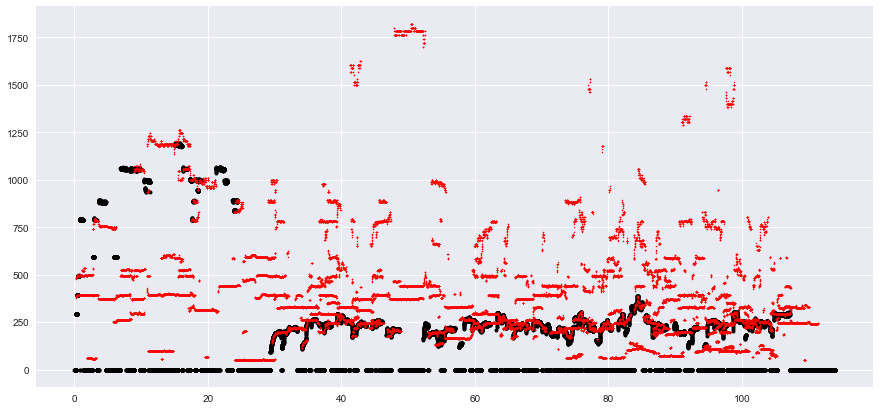

PortStWillow_StayEven


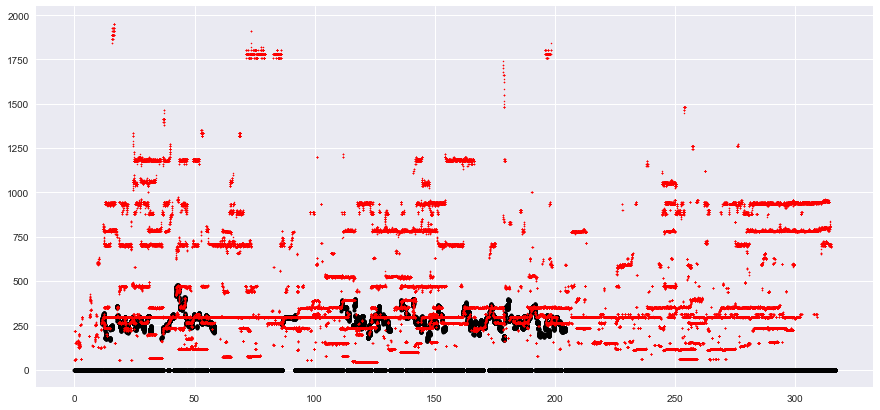

MusicDelta_FusionJazz


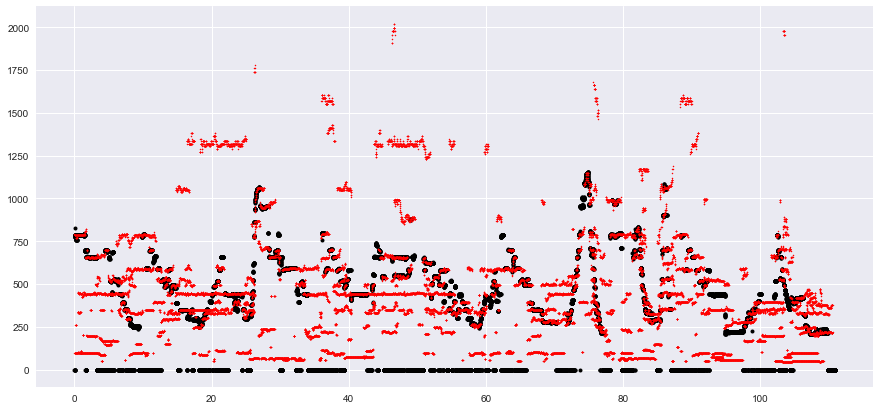

Phoenix_BrokenPledgeChicagoReel


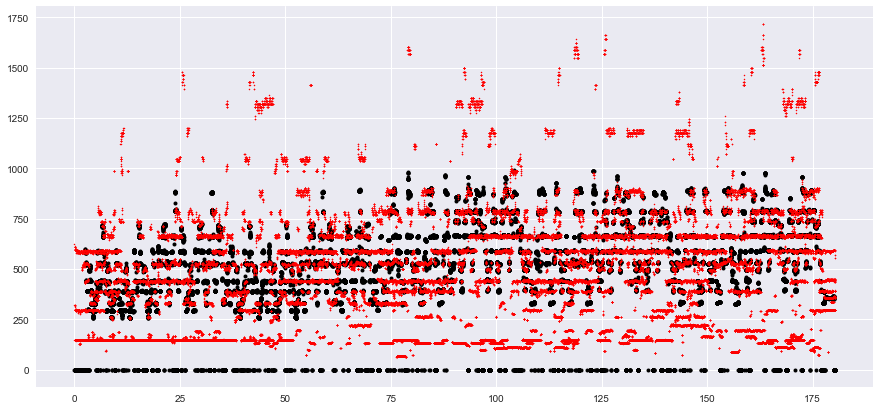

MatthewEntwistle_FairerHopes


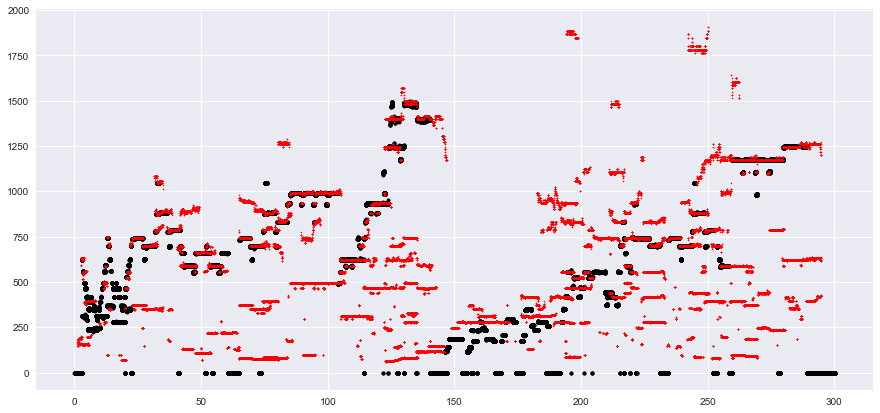

Debussy_LenfantProdigue


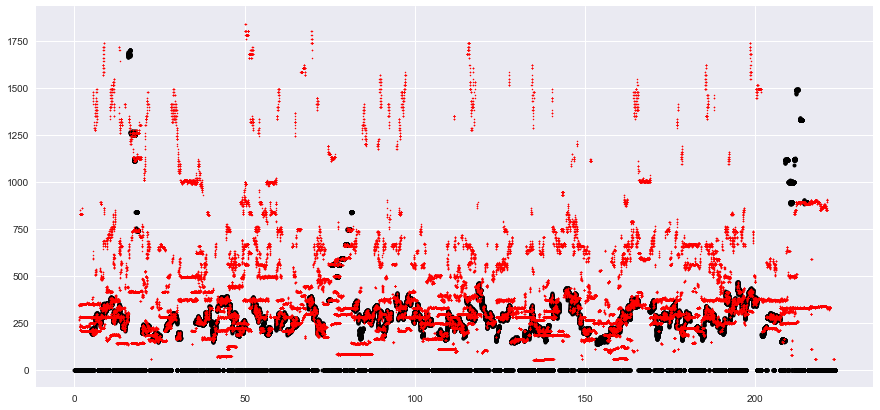

Creepoid_OldTree


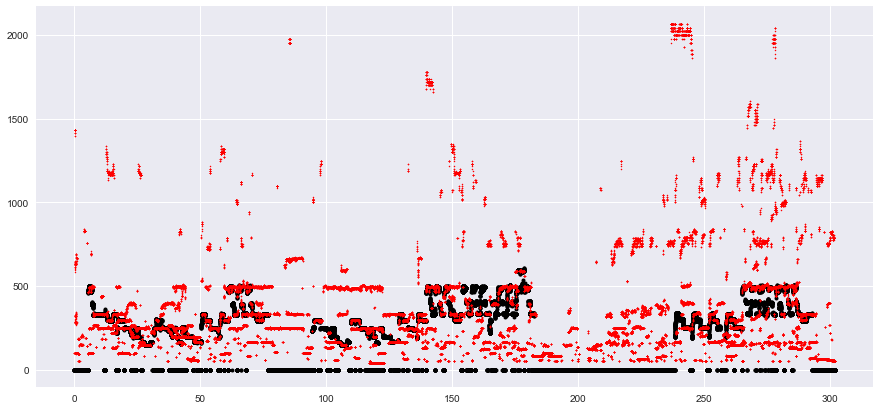

MusicDelta_SwingJazz


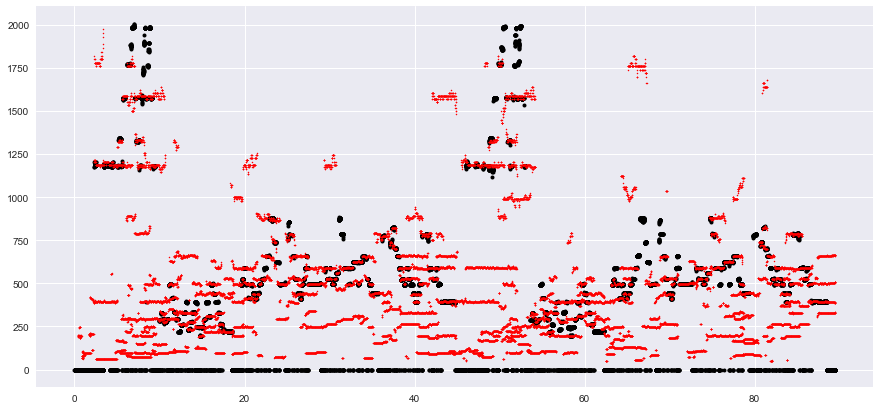

MatthewEntwistle_Lontano


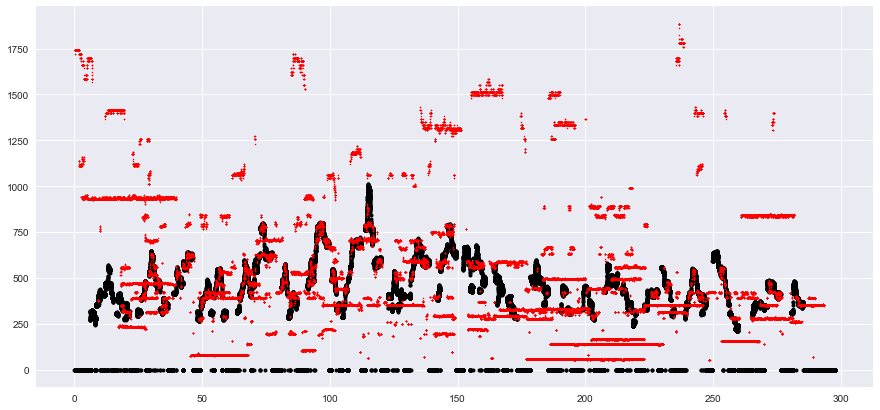

CelestialShore_DieForUs


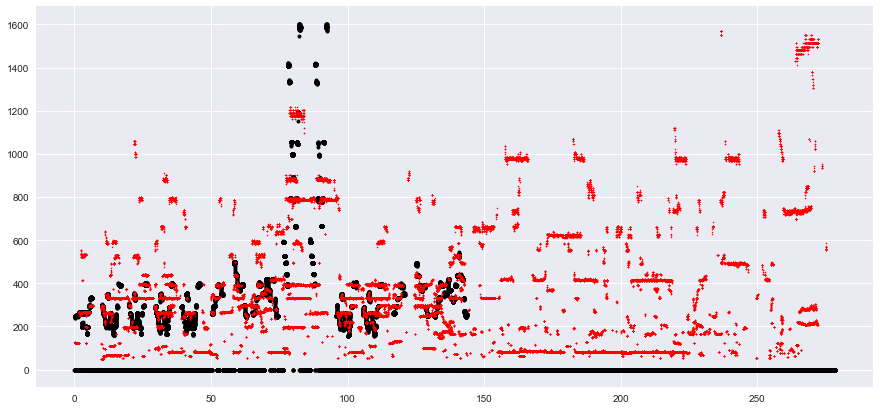

MusicDelta_Pachelbel


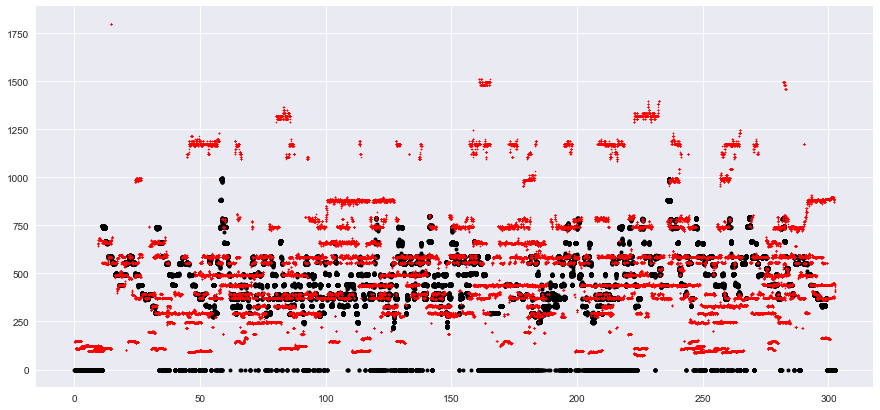

ChrisJacoby_BoothShotLincoln


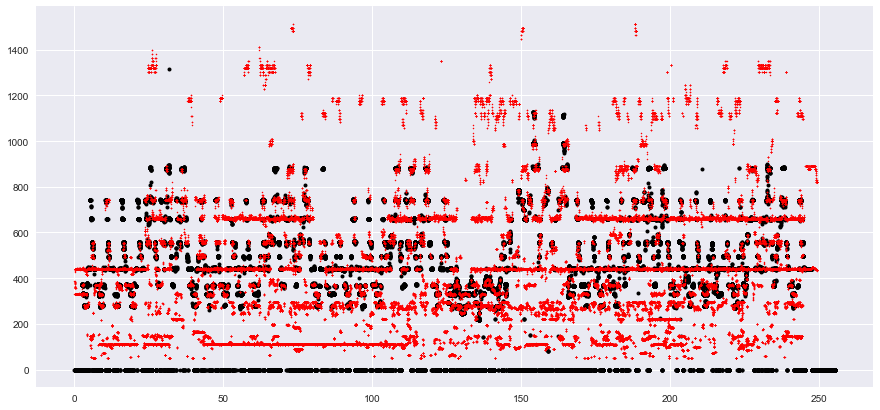

StrandOfOaks_Spacestation


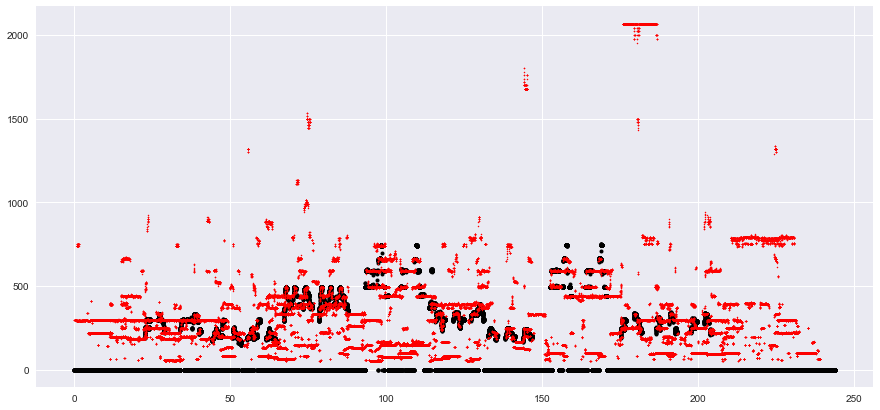

Phoenix_ElzicsFarewell


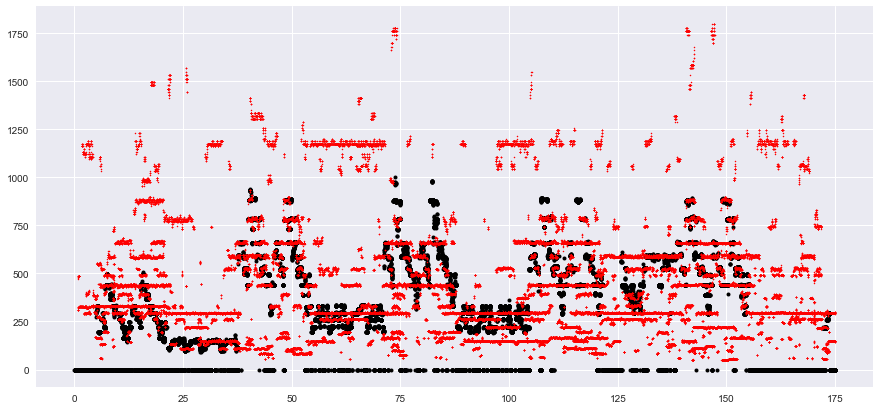

MusicDelta_Gospel


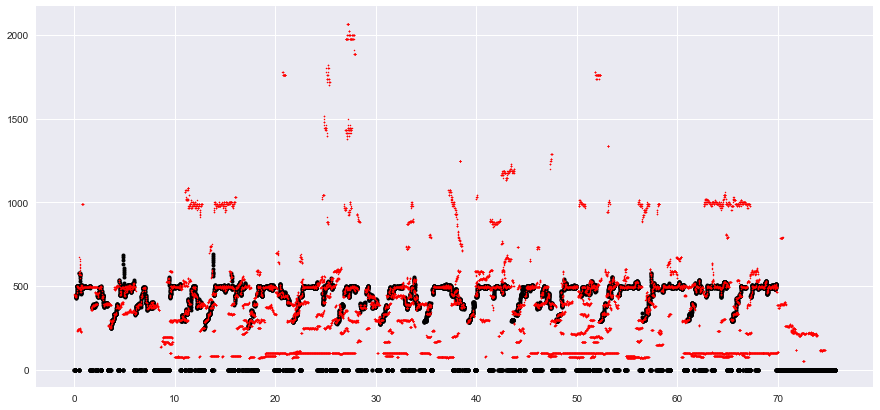

MatthewEntwistle_ImpressionsOfSaturn


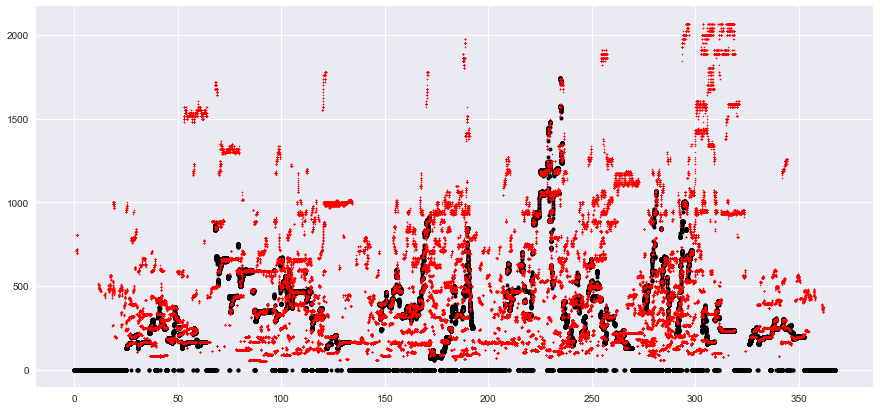

MatthewEntwistle_TheFlaxenField


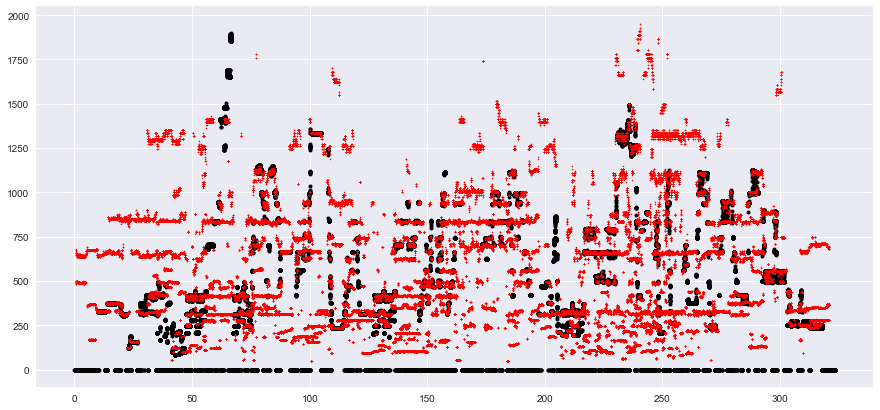

Phoenix_ScotchMorris


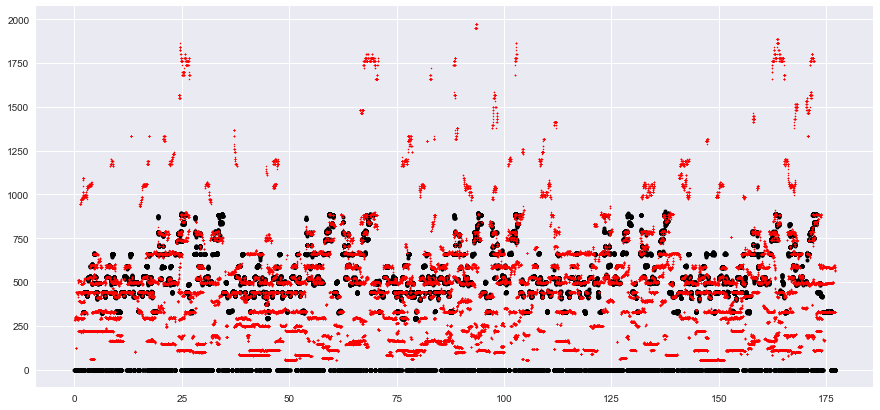

In [34]:
for trackid in test_contours_cnn.keys():
    print(trackid)
    mtrack = mdb.MultiTrack(trackid)
    plt.figure(figsize=(15, 7))
    ctr = test_contours_cnn[trackid]

    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    plt.plot(mel2[0], mel2[1], '.k', markersize=8)
    
    for j, i in enumerate(ctr.nums):
        if test_scores_cnn[trackid][j] >= 0.01:
            plt.plot(ctr.contour_times(i), ctr.contour_freqs(i), '.r', markersize=3)
            
    plt.show()


In [ ]:
thresh_vals = np.arange(0, 0.4, 0.01)
mel_accuracy = {v: [] for v in thresh_vals}

for trackid in zip(valid_contours_cnn.keys(), valid_scores_cnn):
    print(trackid)
    mtrack = mdb.MultiTrack(trackid)

    ctr = valid_contours_cnn[trackid]
    scores = valid_scores_cnn[trackid]    
    
    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])
    for thresh in thresh_vals:
        est_times, est_freqs = max_decode(ctr, scores, thresh)
        mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
        mel_accuracy[thresh].append(mel_scores['Overall Accuracy'])
        print(mel_scores['Raw Pitch Accuracy'])


Phoenix_SeanCaughlinsTheScartaglen


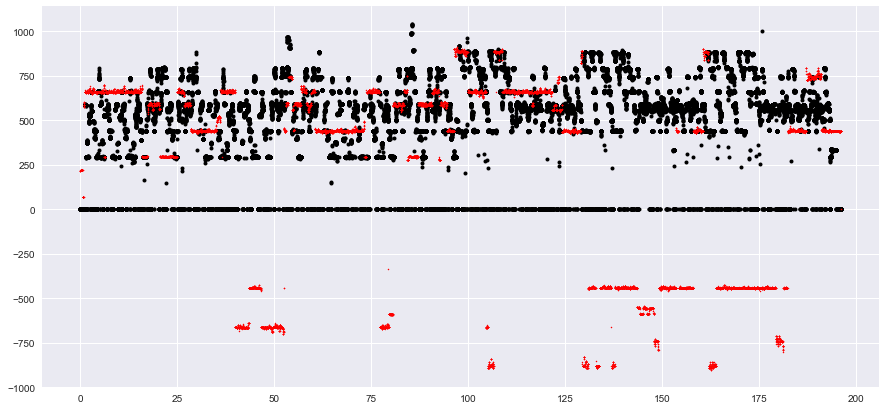

Schubert_Erstarrung


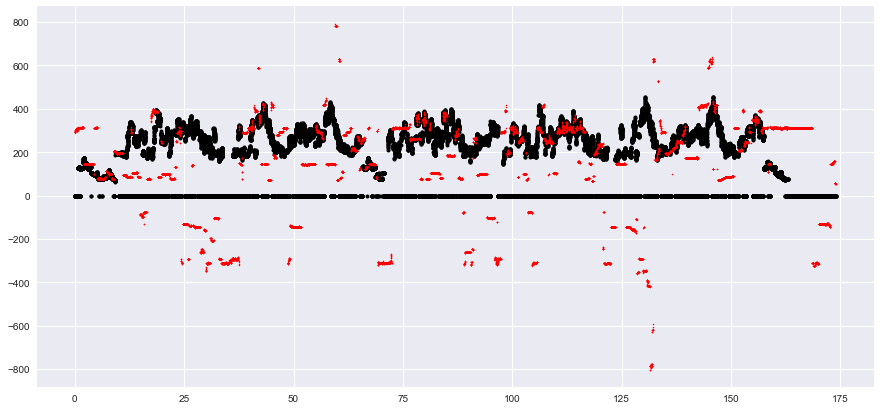

Phoenix_ColliersDaughter


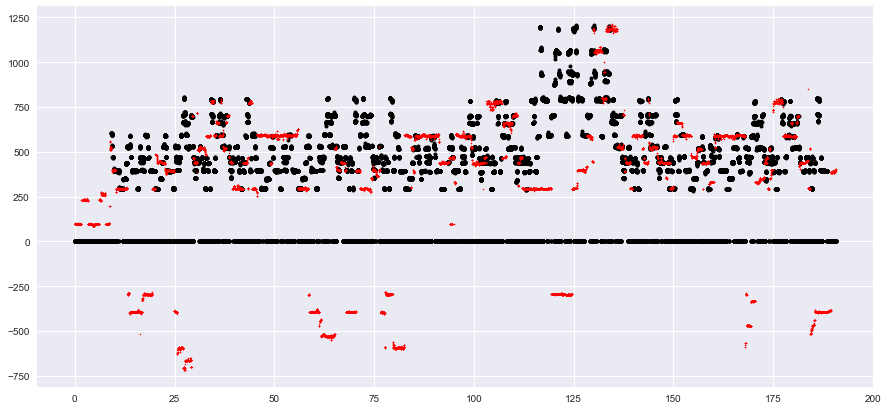

AClassicEducation_NightOwl


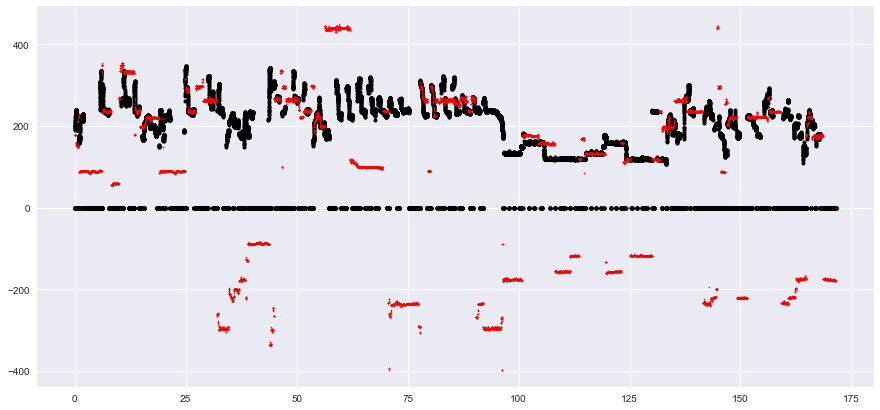

Phoenix_LarkOnTheStrandDrummondCastle


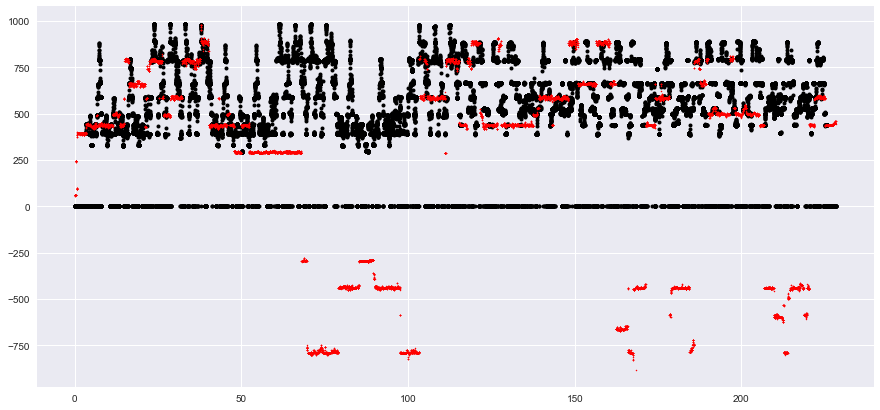

ChrisJacoby_PigsFoot


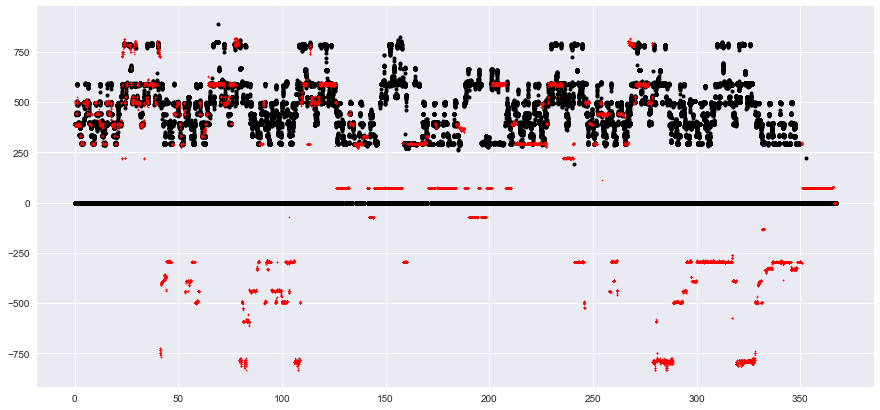

Mozart_DiesBildnis


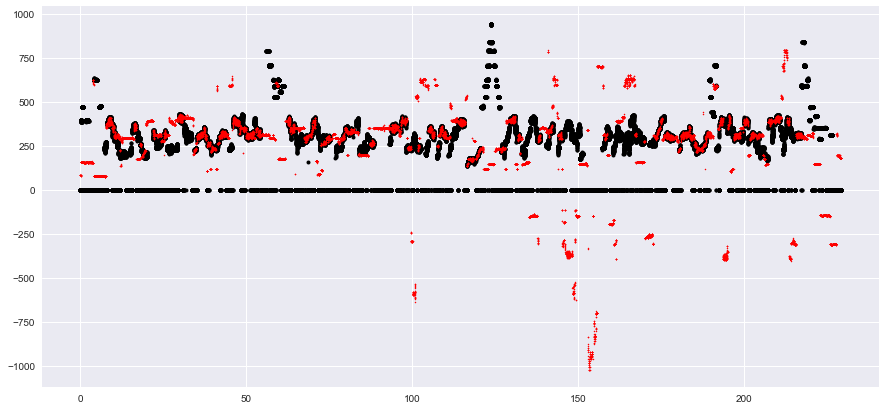

MatthewEntwistle_TheArch


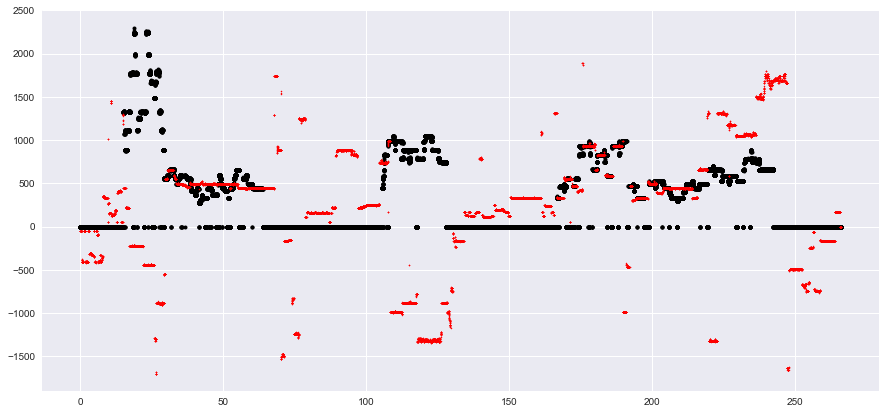

Auctioneer_OurFutureFaces


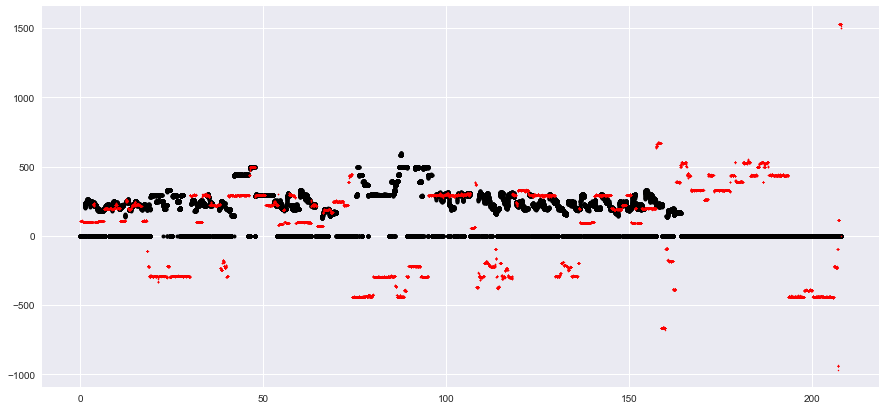

MatthewEntwistle_DontYouEver


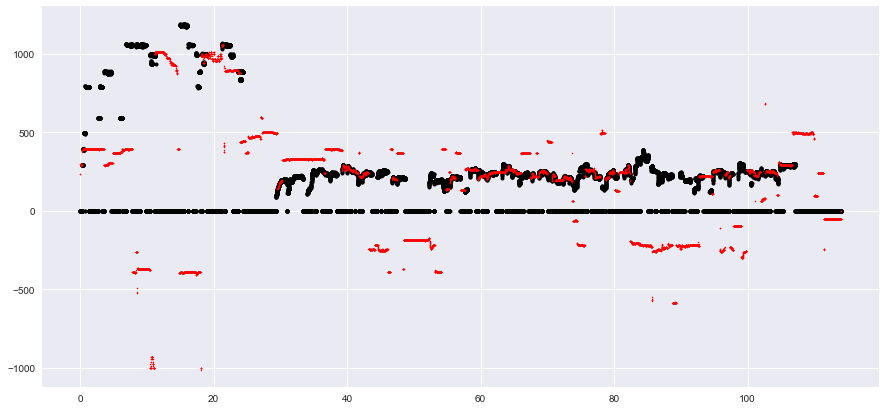

PortStWillow_StayEven


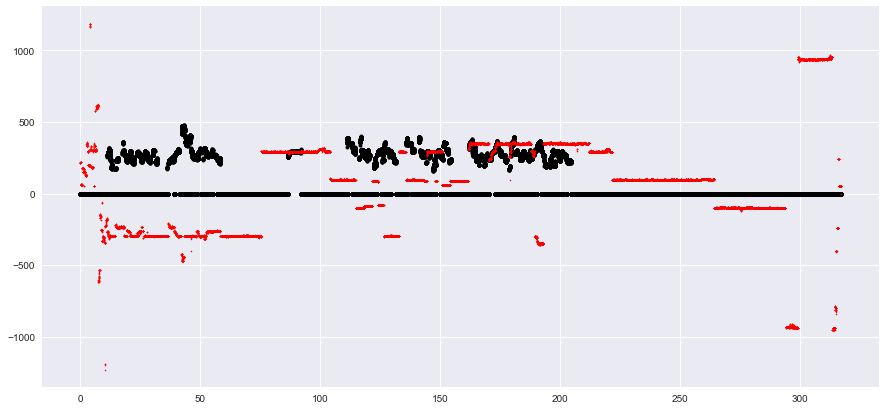

MusicDelta_FusionJazz


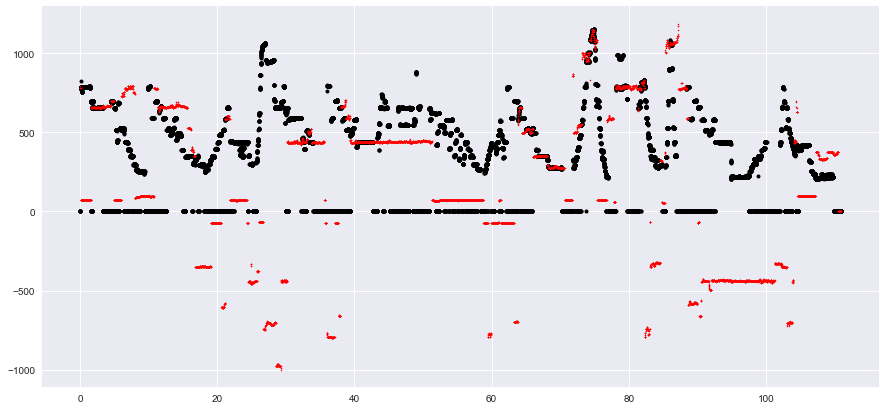

Phoenix_BrokenPledgeChicagoReel


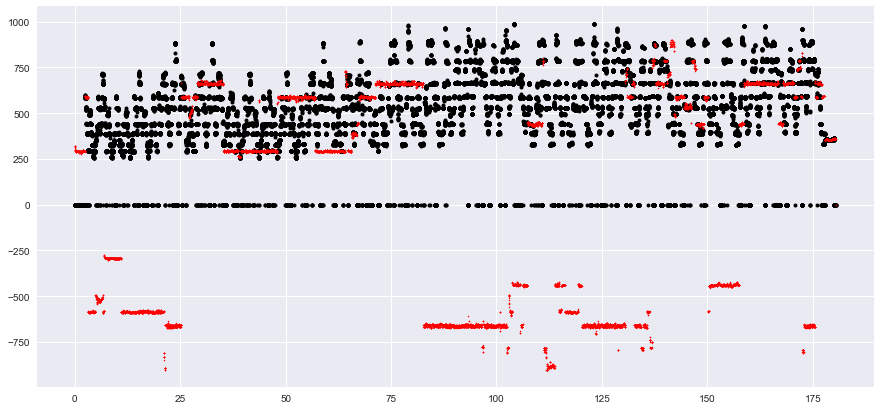

MatthewEntwistle_FairerHopes


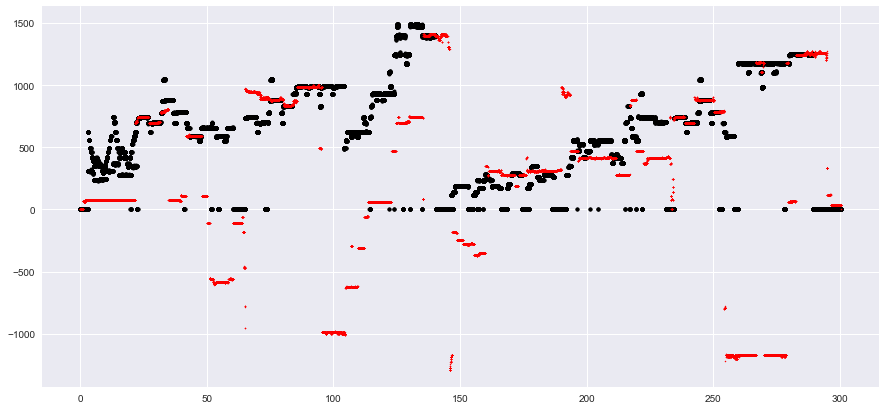

Debussy_LenfantProdigue


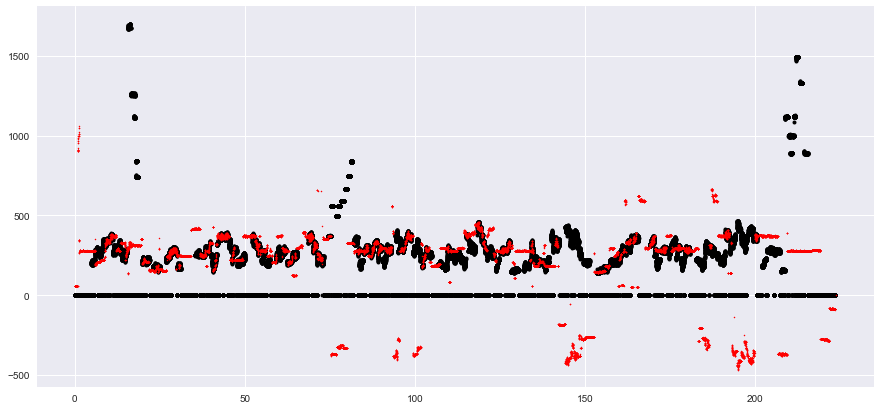

Creepoid_OldTree


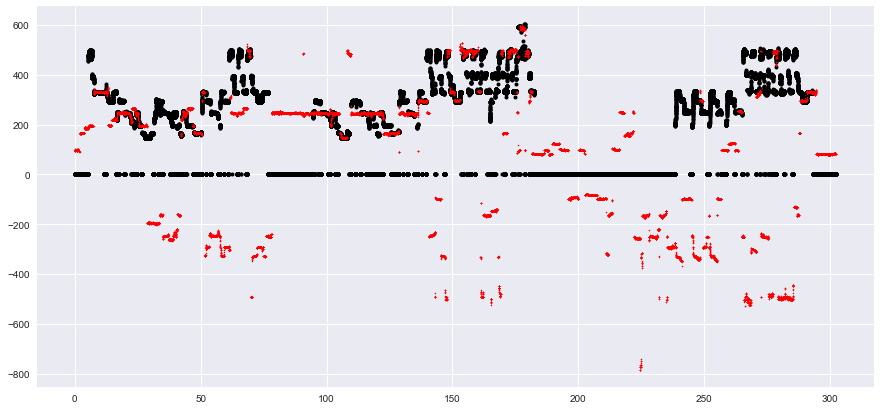

MusicDelta_SwingJazz


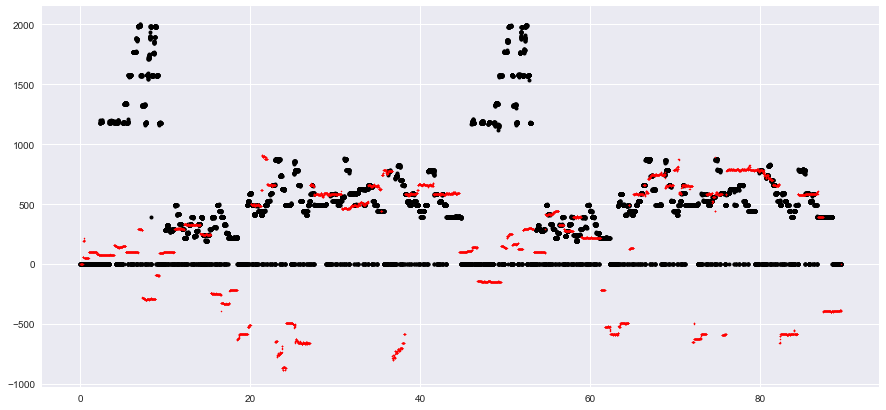

MatthewEntwistle_Lontano


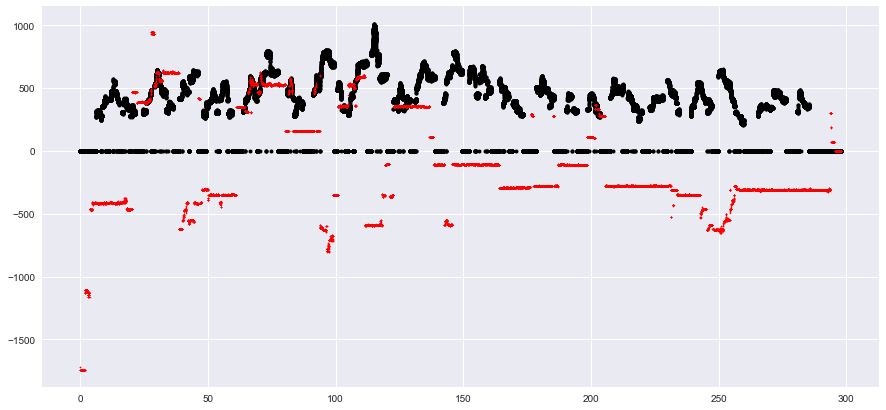

CelestialShore_DieForUs


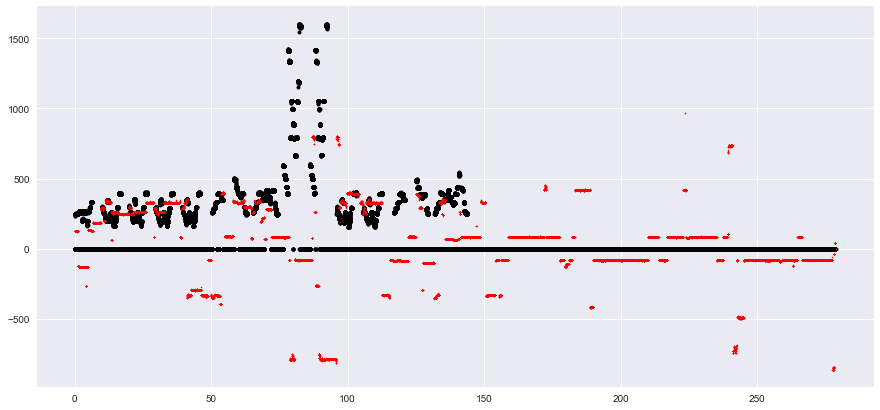

MusicDelta_Pachelbel


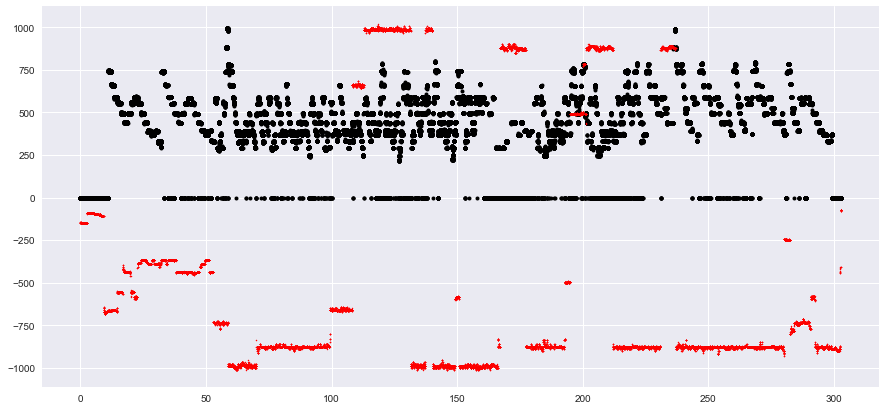

ChrisJacoby_BoothShotLincoln


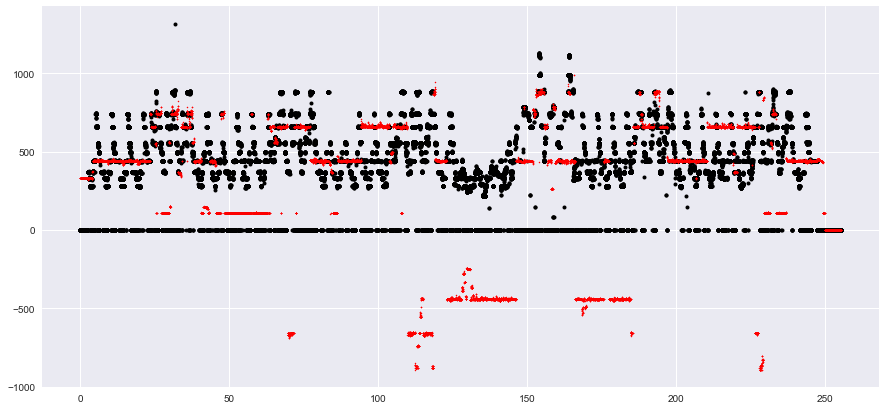

StrandOfOaks_Spacestation


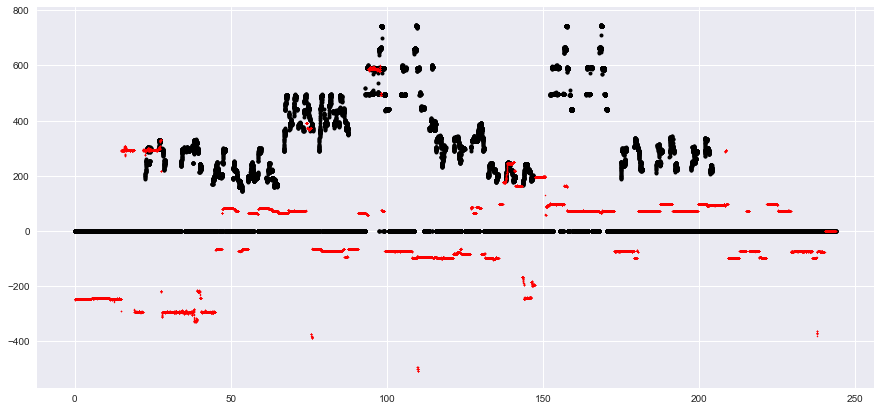

Phoenix_ElzicsFarewell


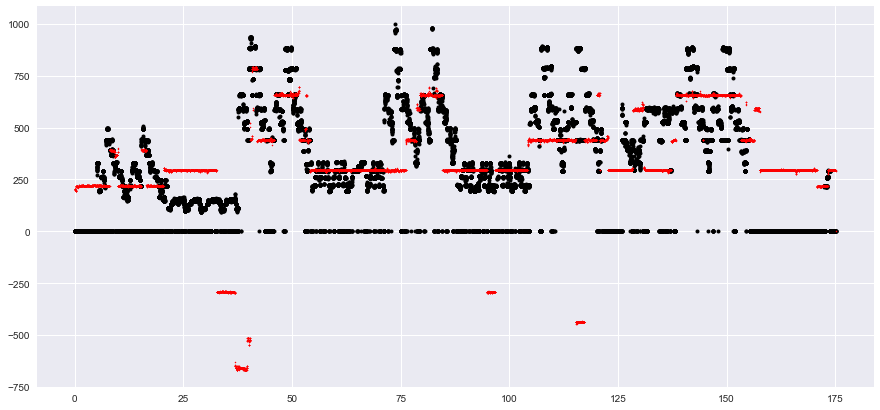

MusicDelta_Gospel


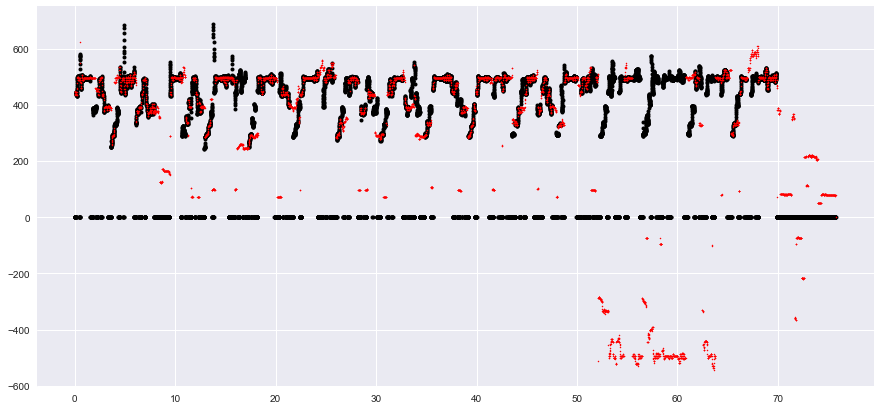

MatthewEntwistle_ImpressionsOfSaturn


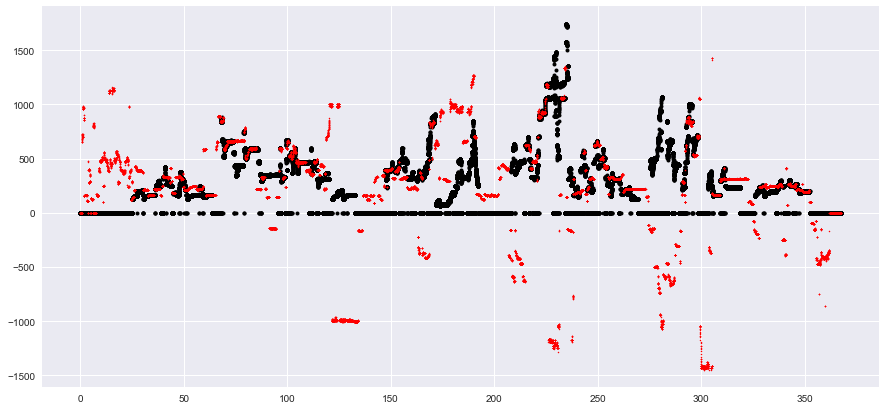

MatthewEntwistle_TheFlaxenField


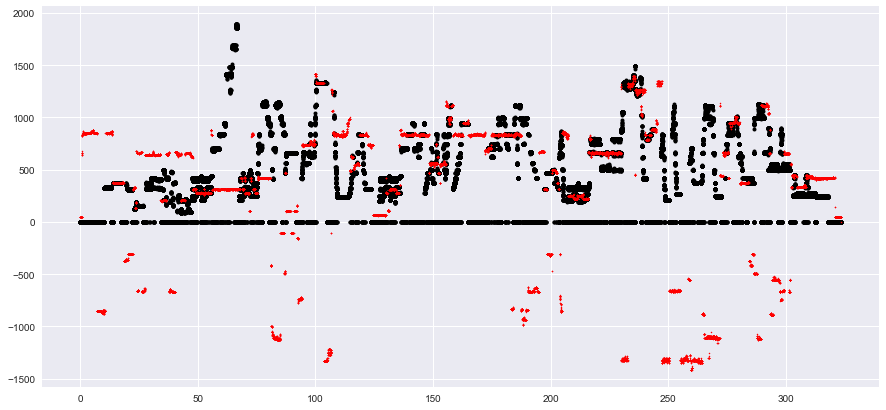

Phoenix_ScotchMorris


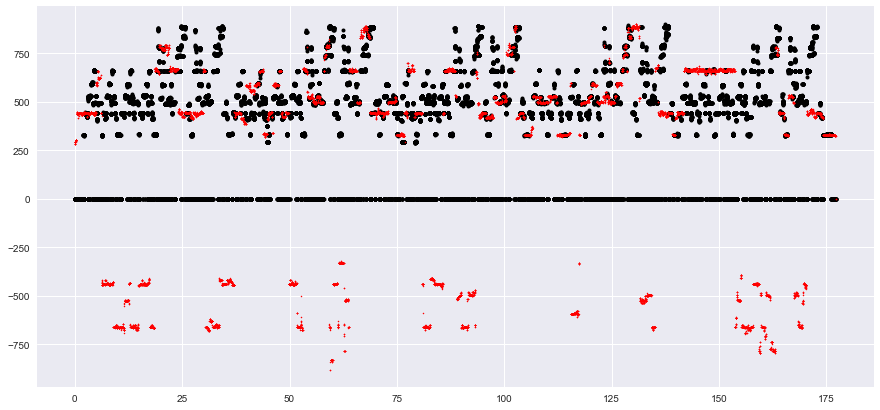

In [47]:
all_mel_scores = []
for trackid in test_contours_cnn.keys():
    print(trackid)
    mtrack = mdb.MultiTrack(trackid)
    
    ctr = test_contours_cnn[trackid]
    scores =test_scores_cnn[trackid]

    mel2 = mtrack.melody2_annotation
    mel2 = np.array(mel2).T
    ref_times, ref_freqs = (mel2[0], mel2[1])
    est_times, est_freqs = weighted_max_decode(ctr, scores, 0.01)

    plt.figure(figsize=(15, 7))
    plt.plot(ref_times, ref_freqs, '.k', markersize=8)
    plt.plot(est_times, est_freqs, '.r', markersize=3)
    plt.show()
#     mel_scores = mir_eval.melody.evaluate(ref_times, ref_freqs, est_times, est_freqs)
#     all_mel_scores.append(mel_scores)

# mel_scores_df = pd.DataFrame(all_mel_scores)

In [40]:
mel_scores_df.describe()

Overall Accuracy  Raw Chroma Accuracy  Raw Pitch Accuracy  \
count         27.000000            27.000000           27.000000   
mean           0.249681             0.358439            0.291616   
std            0.089215             0.124983            0.140697   
min            0.103393             0.199890            0.069968   
25%            0.191609             0.254905            0.196085   
50%            0.245818             0.321843            0.261446   
75%            0.302409             0.423024            0.355895   
max            0.483943             0.775177            0.762960   

       Voicing False Alarm  Voicing Recall  
count            27.000000       27.000000  
mean              0.681425        0.686446  
std               0.160485        0.162125  
min               0.247341        0.188163  
25%               0.655414        0.631329  
50%               0.703135        0.704387  
75%               0.747715        0.784682  
max               0.965947        0.921609

In [ ]:
mel_scores_df.describe()

#### Train Justin's model for melody

In [ ]:
etr_sal = motif.contour_extractors.Salamon()
X_train_sal, Y_train_sal, train_contours_sal = \
    get_XY_pairs(etr_sal, ftr_bitt, file_pairs_train)
X_test_sal, Y_test_sal, test_contours_sal = \
    get_XY_pairs(etr_sal, ftr_bitt, file_pairs_test)

In [ ]:
clf_sal = motif.contour_classifiers.RandomForest()
clf_sal.fit(X_train_sal, Y_train_sal)

In [ ]:
# get training score
Y_prob_sal = clf_sal.predict(X_train_sal)
Y_pred = (np.array(Y_prob_sal >= clf_sal.threshold)).astype(int)
train_scores = clf_sal.score(Y_pred, Y_train, y_prob=Y_prob)

### Train contour classification

In [ ]:
feat_idx = range(len(ftr_bitt.feature_names))
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
plt.plot(feat_idx, clf_cnn.clf.feature_importances_, '.')
plt.xticks(feat_idx, ftr_bitt.feature_names, rotation='vertical')
plt.subplot(1,2,2)
plt.plot(feat_idx, clf_sal.clf.feature_importances_, '.')
plt.xticks(feat_idx, ftr_bitt.feature_names, rotation='vertical')
plt.show()

### Get melody output - Justin

In [ ]:
valid_contour_list_sal, valid_scores_list_sal = get_contour_scores_sal(
    etr_sal, ftr_bitt, clf_sal, file_pairs_validate
)

test_contour_list_cnn, test_scores_list_cnn = get_contour_scores_sal(
    etr_sal, ftr_bitt, clf_sal, file_pairs_test
)

### Score melody output